In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import copy
from EVFleet import * 
import pandas as pd
import sys

In [5]:
def create_energy_set(start, M, H, pv, wt):
    days = 365 // M -1
    q = np.zeros((M, H))
    Q = np.zeros((M, days * 24))
    for m in range(M):
        start_idx = m * days * 24
        end_idx = (m + 1) * days * 24
        Q[m, :] = pv[start_idx:end_idx] + wt[start_idx:end_idx]
        q[m, :] = Q[m, start:start+H]

    return q

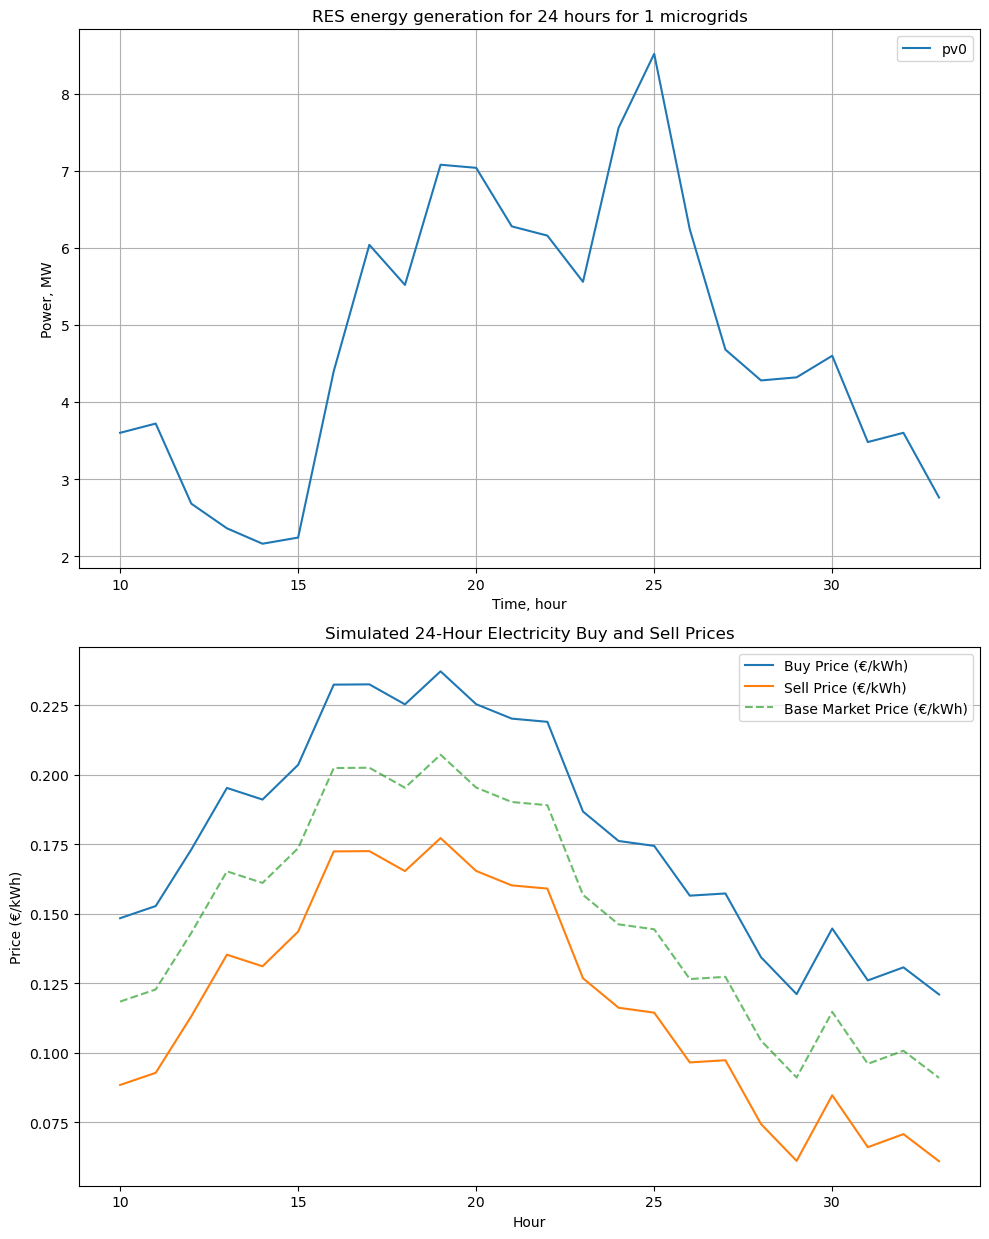

In [8]:
DAYS = 1
H=24
M=1
N=10
start = 10

# Set seed for reproducibility
np.random.seed(42)

hours = np.arange(start, start + 24 * DAYS)
base_price = 0.15
amplitude = 0.10

noise = np.random.normal(0, 0.01, size=24*DAYS)
# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)
    
# Add asymmetric buy/sell prices
margin = 0.03
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices

# Load CSV data
pv_energy = '2023_photovoltaic_total_at.csv'  # Replace with your actual file path
wt_energy = '2023_windpower_total_at.csv'  # Replace with your actual file path

pv = pd.read_csv(pv_energy, delimiter=';')
wt = pd.read_csv(wt_energy, delimiter=';')

pv_arr = pv['Power (MW)'].to_numpy()
wt_arr = wt['Power (MW)'].to_numpy()


q = create_energy_set(start, M, H*DAYS, pv_arr, wt_arr) / 100

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns

axs[0].set_title(f'RES energy generation for {H*DAYS} hours for {M} microgrids')
for m in range(M): 
    axs[0].plot(np.arange(start, start+H*DAYS), q[m,:], label=f"pv{m}")
axs[0].legend()
axs[0].set_xlabel('Time, hour')
axs[0].set_ylabel('Power, MW')
axs[0].grid(True)
# First subplot: Buy and Sell Prices
axs[1].plot(hours, c, label='Buy Price (€/kWh)')
axs[1].plot(hours, p, label='Sell Price (€/kWh)')
axs[1].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[1].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Price (€/kWh)")
axs[1].grid(axis='y')
axs[1].legend()

plt.tight_layout()
plt.savefig("MPC environmental parameters", dpi=300)
plt.show()

In [11]:
fleet = EVFleet(xlsx_path='EV_UsageProfile.xlsx', num_vehicles=N*M)
results = fleet.simulate_multiple_days(num_days=DAYS)
N = 10
M = 1
L_usage_global = np.zeros((M,N,DAYS+1,4), dtype='int')
for row in results:
    L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 0] = int(row['Initial SoC']) / 100
    L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 1] = int(row['Goal (kWh)']) / 100
    L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 2] = int(row['Arrival (h)']) + 24 * (row['Day'] - 1) - start
    #L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 3] = int(row['Departure (h)']) + 24 * (row['Day']) - start if int(row['Departure (h)']) + 24 * (row['Day'])  - start < 23 + 24 * (row['Day']) -start  else 21 + 24 * (row['Day']) - start
    L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 3] = int(row['Departure (h)']) + 24 * (row['Day']) - start if int(row['Departure (h)']) + 24 * (row['Day']) - start < 23 else 22
    print(row['EV'] // N, row['EV'] % N, L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, :])

0 0 [10 80  6 20]
0 1 [13 80  4 21]
0 2 [18 80  3 20]
0 3 [18 80  7 21]
0 4 [12 40  1 22]
0 5 [16 80  7 21]
0 6 [12 80  6 20]
0 7 [16 80  6 20]
0 8 [14 80  6 20]
0 9 [13 80  4 21]


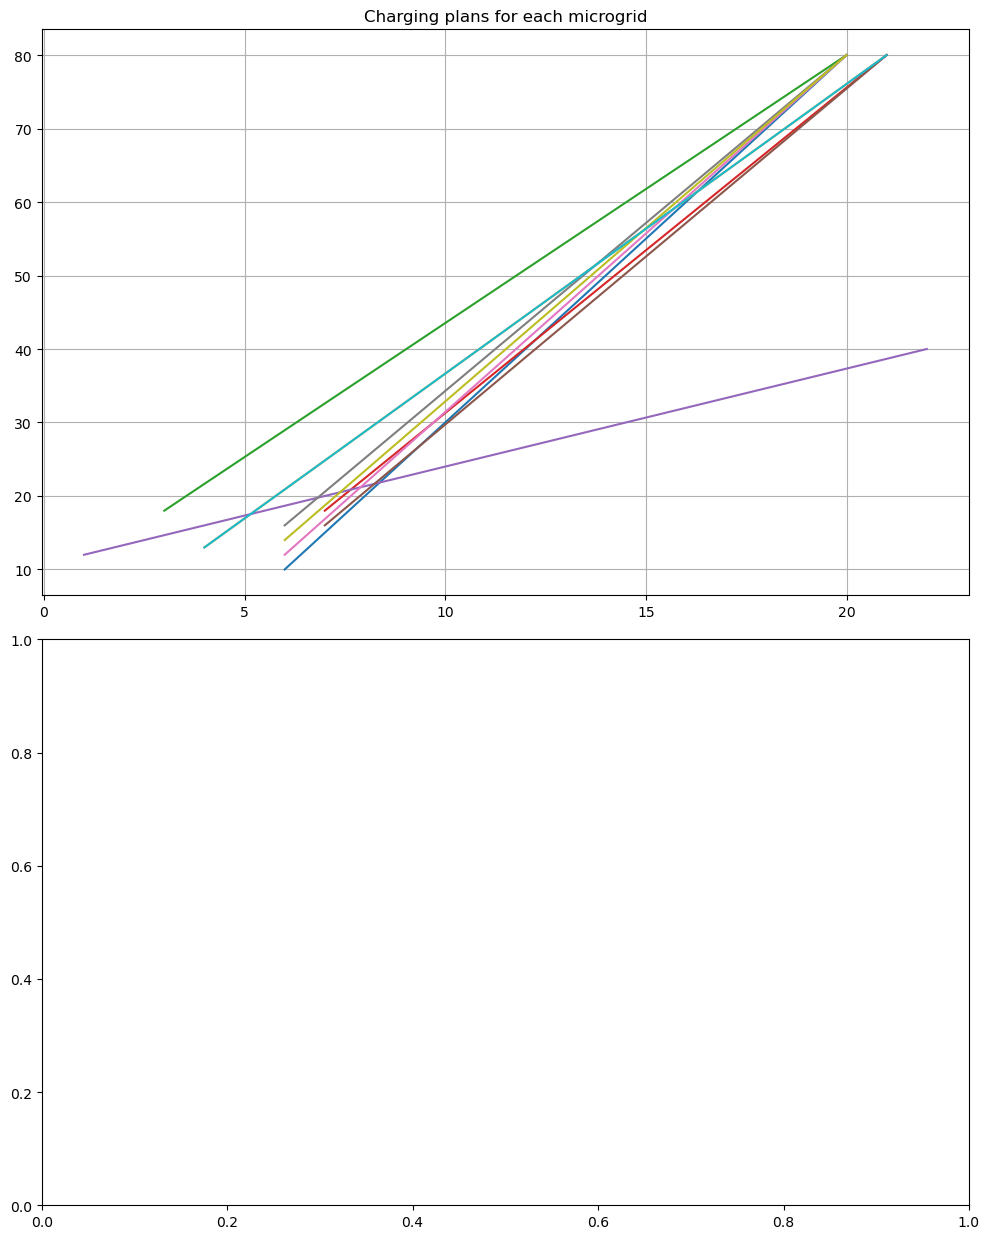

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10,12.5))
for d in range(DAYS):
    for m in range(M):
        for n in range(N):
            L_init, L_target, L_arrival, L_dep = L_usage_global[m,n,d,:]
            y = [L_init, L_target]
            x = [L_arrival, L_dep]
            axs[m].plot(x,y)
            axs[m].grid(True)
axs[0].set_title("Charging plans for each microgrid");
plt.tight_layout()
plt.savefig("Charging plans for each microgrid", dpi=300)
plt.show()

L_target = L_usage_global[:,:,0,1]
L_init = L_usage_global[:,:,0,0]
L_arrival = L_usage_global[:,:,0,2]
L_depart = L_usage_global[:,:,0,3]